# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.preprocessing import label_binarize

# Dataset info

File: /kaggle/input/mlsci-lenses-task1/dataset/train/no/1.npy
Shape of the array: (1, 150, 150)
Data type of the array: float64
Min value in the array: 0.0
Max value in the array: 1.0
Sample data (first 5 elements): [0.0130039  0.00910273 0.01820546 0.01560468 0.01690507]

File: /kaggle/input/mlsci-lenses-task1/dataset/train/sphere/1.npy
Shape of the array: (1, 150, 150)
Data type of the array: float64
Min value in the array: 0.0
Max value in the array: 1.0
Sample data (first 5 elements): [0.01728723 0.00930851 0.0106383  0.01462766 0.01196809]

File: /kaggle/input/mlsci-lenses-task1/dataset/train/vort/1.npy
Shape of the array: (1, 150, 150)
Data type of the array: float64
Min value in the array: 0.0
Max value in the array: 1.0
Sample data (first 5 elements): [0.0123119  0.00957592 0.00820793 0.01504788 0.00547196]



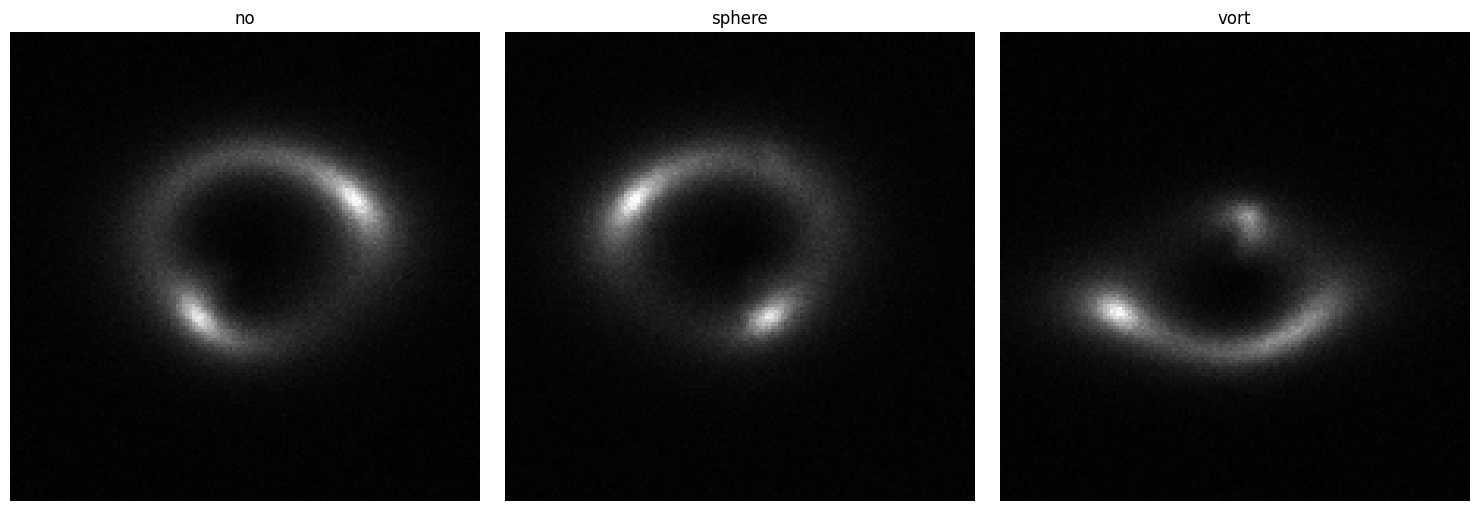

In [2]:
# Define the file paths
file_paths = [
    '/kaggle/input/mlsci-lenses-task1/dataset/train/no/1.npy',
    '/kaggle/input/mlsci-lenses-task1/dataset/train/sphere/1.npy',
    '/kaggle/input/mlsci-lenses-task1/dataset/train/vort/1.npy'
]

# Create a figure to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the file paths and display each image
for ax, file_path in zip(axes, file_paths):
    # Load the .npy file
    image_data = np.load(file_path)
    
    # Print the shape of the array
    print(f"File: {file_path}")
    print("Shape of the array:", image_data.shape)

    # Print the data type of the array
    print("Data type of the array:", image_data.dtype)

    # Print the minimum and maximum values in the array
    print("Min value in the array:", np.min(image_data))
    print("Max value in the array:", np.max(image_data))

    # Optionally, print a small portion of the data
    print("Sample data (first 5 elements):", image_data.flatten()[:5])
    print()  # Print a newline for better readability

    # Remove the extra dimension
    image_data = np.squeeze(image_data)
    
    # Display the image
    ax.imshow(image_data, cmap='gray')  # Use 'gray' if it's a grayscale image
    ax.axis('off')  # Turn off axis labels
    ax.set_title(file_path.split('/')[-2])  # Set title to the category name

# Show the images
plt.tight_layout()
plt.show()

# Custom Dataset for NPY Files

In [3]:
class LensNPYDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {'no': 0, 'sphere': 1, 'vort': 2}
        self.class_counts = {class_name: 0 for class_name in self.class_to_idx.keys()}

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith('.npy'):
                        self.samples.append((os.path.join(class_path, file), self.class_to_idx[class_name]))
                        self.class_counts[class_name] += 1  # Increment count for the class

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path)  # shape: (1, 150, 150)
    
        if image.ndim == 3 and image.shape[0] == 1:
            # Convert (1, H, W) to (H, W)
            image = image.squeeze(0)
    
        # Convert to 3-channel by duplicating the grayscale channel
        image = np.stack([image] * 3, axis=-1)  # shape: (H, W, 3)
    
        # Convert to PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))  # still [0, 1] normalized
    
        if self.transform:
            image = self.transform(image)
    
        return image, label

    def get_class_counts(self):
        return self.class_counts

# Transforms and Data Loaders

In [4]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [5]:
train_dir = "/kaggle/input/mlsci-lenses-task1/dataset/train"
val_dir = "/kaggle/input/mlsci-lenses-task1/dataset/val"

train_dataset = LensNPYDataset(train_dir, transform=transform)
val_dataset = LensNPYDataset(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("Training dataset class counts:")
for class_name, count in train_dataset.get_class_counts().items():
    print(f"{class_name}: {count} items")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("\nValidation dataset class counts:")
for class_name, count in val_dataset.get_class_counts().items():
    print(f"{class_name}: {count} items")

Training dataset class counts:
no: 10000 items
sphere: 10000 items
vort: 10000 items

Validation dataset class counts:
no: 2500 items
sphere: 2500 items
vort: 2500 items


In [6]:
sample_img, sample_label = train_dataset[0]
print(f"Sample shape: {sample_img.shape}, Label: {sample_label}")

Sample shape: torch.Size([3, 150, 150]), Label: 0


# Visualize Sample Images

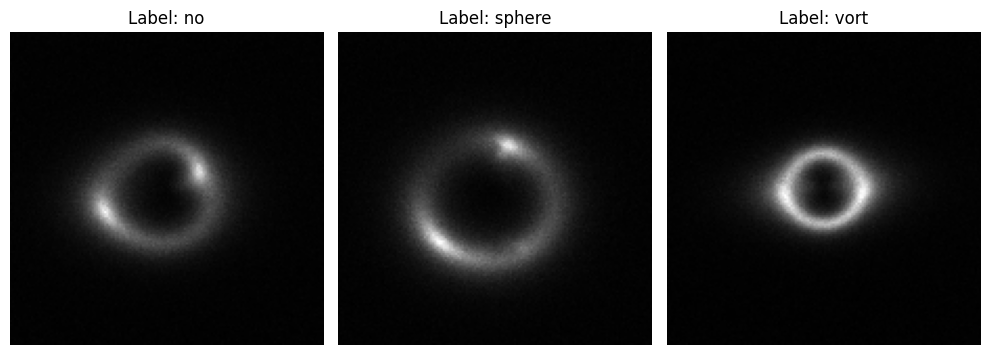

In [7]:
def imshow_tensor(img_tensor, label):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Move to CPU if necessary
    img = img * 0.5 + 0.5  # Adjust this line based on your normalization
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')

# Class names
class_names = ['no', 'sphere', 'vort']

# Find one image per class
images_per_class = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label_name = class_names[label.item()]  # Ensure label is an integer
        if label_name not in images_per_class:
            images_per_class[label_name] = img
        if len(images_per_class) == 3:
            break
    if len(images_per_class) == 3:
        break

# Plot the images
plt.figure(figsize=(10, 4))
for idx, class_name in enumerate(class_names):
    plt.subplot(1, 3, idx + 1)
    imshow_tensor(images_per_class[class_name], class_name)

plt.tight_layout()
plt.show()

# Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes: no, sphere, vort
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


# Loss, Optimizer, and Train Function

In [9]:
learning_rate = 0.001
epochs = 25
criterion = nn.CrossEntropyLoss
optimizer_class = torch.optim.Adam

def train_model(model, train_loader, val_loader, epochs=epochs, learning_rate=learning_rate, criterion=criterion, optimizer_class=optimizer_class):
    criterion = criterion()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    epoch_times = []

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        # ----- Training -----
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ----- Validation -----
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start
        epoch_times.append(epoch_duration)

        print(f"📊 Epoch [{epoch+1}/{epochs}] - Time: {epoch_duration:.2f}s")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"   Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print("-" * 50)

    total_time = time.time() - total_start_time
    total_time_minutes = total_time / 60  # Convert to minutes
    print(f"✅ Total Training Time: {total_time_minutes:.2f} minutes")

    # ----- Plotting -----
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Acc', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Val Acc', marker='o')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training

📊 Epoch [1/25] - Time: 377.12s
   Train Loss: 1.0525 | Train Acc: 0.4090
   Val   Loss: 1.1817 | Val   Acc: 0.4565
--------------------------------------------------
📊 Epoch [2/25] - Time: 117.99s
   Train Loss: 0.6103 | Train Acc: 0.7392
   Val   Loss: 0.6014 | Val   Acc: 0.7735
--------------------------------------------------
📊 Epoch [3/25] - Time: 145.27s
   Train Loss: 0.3928 | Train Acc: 0.8489
   Val   Loss: 0.4620 | Val   Acc: 0.8177
--------------------------------------------------
📊 Epoch [4/25] - Time: 152.37s
   Train Loss: 0.3174 | Train Acc: 0.8805
   Val   Loss: 0.3874 | Val   Acc: 0.8525
--------------------------------------------------
📊 Epoch [5/25] - Time: 138.89s
   Train Loss: 0.2693 | Train Acc: 0.9012
   Val   Loss: 0.3074 | Val   Acc: 0.8907
--------------------------------------------------
📊 Epoch [6/25] - Time: 124.17s
   Train Loss: 0.2374 | Train Acc: 0.9129
   Val   Loss: 0.3535 | Val   Acc: 0.8668
--------------------------------------------------
📊 Ep

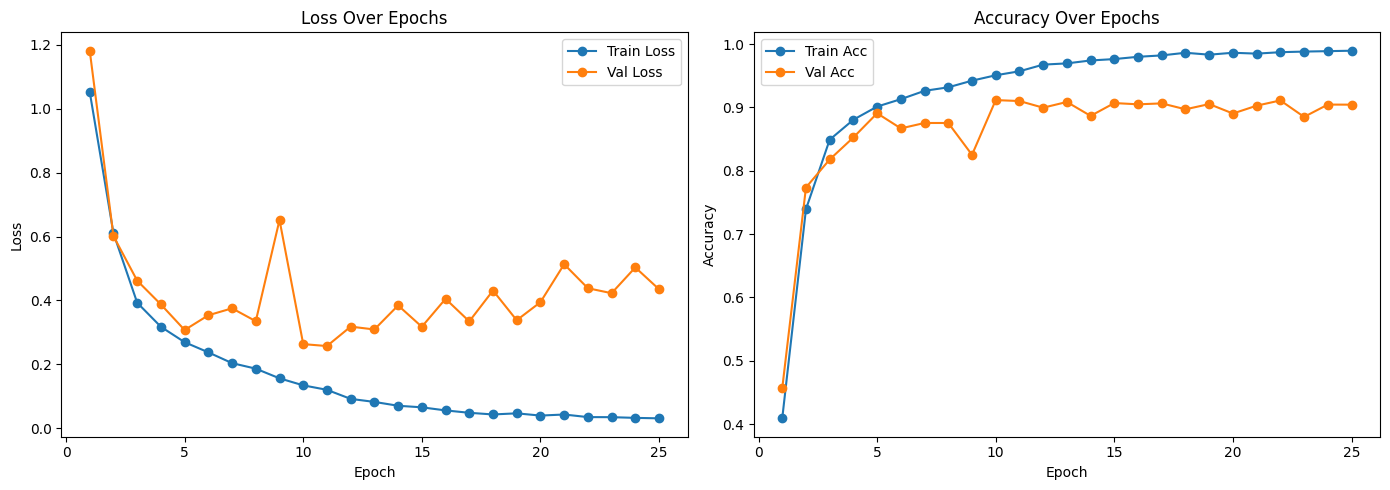

In [10]:
train_model(model, train_loader, val_loader, epochs=25)

In [14]:
model_save_path = 'trained_model.pth'
torch.save(model.state_dict(), model_save_path)

# Evaluate with ROC Curve and AUC Score

In [11]:
def evaluate_model(model, val_loader, class_names=['no', 'sphere', 'vort']):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            y_scores.extend(probs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)

    # Binarize for AUC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
    print(f"📈 AUC Score: {auc:.4f}")

    # ROC Curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Remove accuracy, macro avg, and weighted avg from the report
    report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    print("📊 Classification Report (Quantitative Analysis):")
    display(report_df)

    # Optional: Print metrics separately (if needed)
    # You can keep or remove these lines based on your requirements
    print(f"\n✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Macro Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"✅ Macro Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"✅ Macro F1-Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

📈 AUC Score: 0.9773


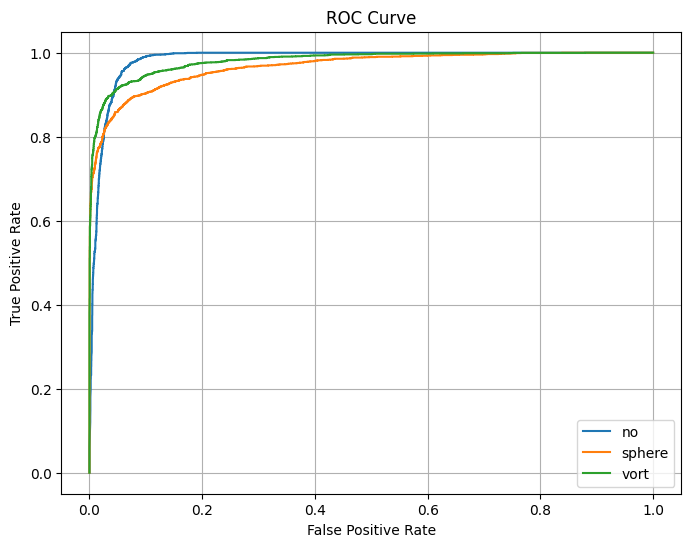

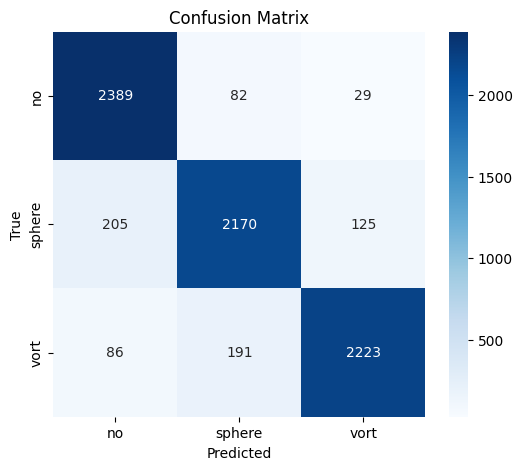

📊 Classification Report (Quantitative Analysis):


,precision,recall,f1-score,support
no,0.891418,0.9556,0.922394,2500.0
sphere,0.888252,0.8680,0.878009,2500.0
vort,0.935212,0.8892,0.911626,2500.0



✅ Accuracy: 0.9043
✅ Macro Precision: 0.9050
✅ Macro Recall: 0.9043
✅ Macro F1-Score: 0.9040


In [12]:
evaluate_model(model, val_loader, class_names=['no', 'sphere', 'vort'])

# Result

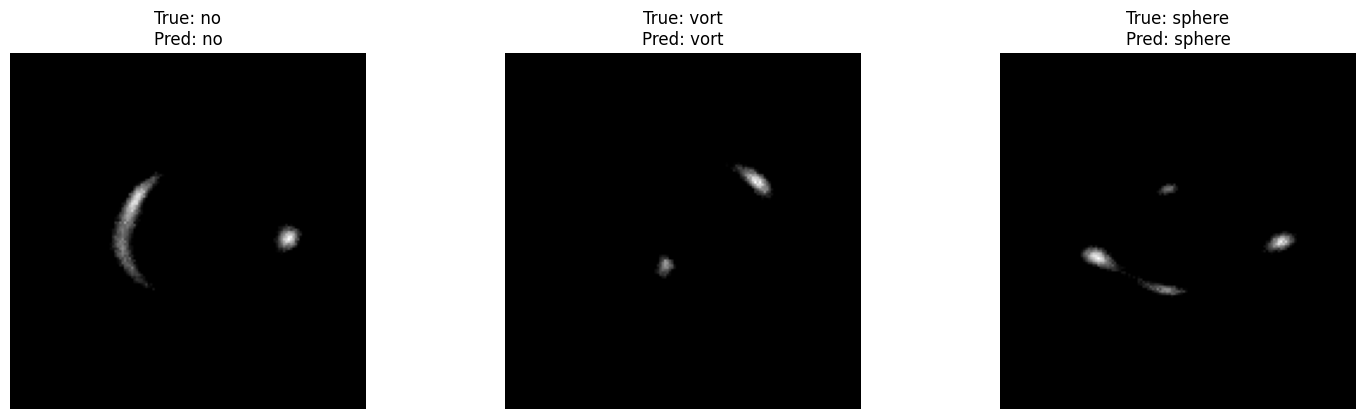

In [13]:
def show_predictions_ensure_classes(model, dataloader, class_names, num_images=6):
    model.eval()
    shown_per_class = {}
    total_shown = 0

    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                true_class = labels[i].item()

                # Check if we already have an example of this class
                if true_class in shown_per_class:
                    continue

                # Convert image for display
                img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                if img.shape[2] == 1:
                    img = img.squeeze(-1)

                true_label = class_names[true_class]
                pred_label = class_names[preds[i].item()]

                plt.subplot(2, 3, total_shown + 1)
                plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
                plt.title(f"True: {true_label}\nPred: {pred_label}")
                plt.axis('off')

                shown_per_class[true_class] = True
                total_shown += 1

                if total_shown >= num_images or len(shown_per_class) == len(class_names):
                    break

            if total_shown >= num_images or len(shown_per_class) == len(class_names):
                break

    plt.tight_layout()
    plt.show()

show_predictions_ensure_classes(model, val_loader, class_names=['no', 'sphere', 'vort'], num_images=6)

In [17]:
'''
Model is overfitting can use data augmentation or reguralization techniques
'''

'\nModel is overfitting can use data augmentation or reguralization techniques\n'